Our problem:

\begin{align*}
\tag{1}
& \dot{S} & = & -\lambda S + \frac{P}{di} + \frac{N}{di}&\\ \\
\tag{2}
& \dot{I} & = &  \lambda S - I \frac{1}{wip} - I \frac{1}{dai} &\\ \\
\tag{3}
& \dot{G} & = &  I \frac{1}{wip} - G \frac{1}{dwt} &\\ \\ 
\tag{4}
& \dot{P} & = &  I \frac{psc}{dai} + G \frac{psc}{dwt} - P \frac{1}{di} &\\ \\
\tag{5}
& \dot{N} & = &  I \frac{1-psc}{dai} + G \frac{1-psc}{dwt} - N \frac{1}{di} &\\ \\
\end{align*}

We define:

\begin{equation*}
\mathbf{X} = \begin{bmatrix} S & I & G & P & N \end{bmatrix}^T
\end{equation*}

\begin{equation*}
\mathbf{\theta} = \begin{bmatrix} \lambda & di & wip & dai & dwt & psc \end{bmatrix}^T
\end{equation*}

#### Stoichiometry matrix

\begin{equation*}
A = \begin{bmatrix}
    -1 & 1  & 1  & 0  & 0  & 0  & 0 & 0 & 0  & 0 & 0 \\
    1  & 0  & 0  & -1 & -1 & 0  & 0 & 0 & 0  & 0 & 0 \\
    0  & 0  & 0  & 1  & 0  & -1 & 0 & 0 & 0  & 0 & 0 \\
    0  & 0  & 0  & 0  & 0  & 0  & 1 & 1 & -1 & 0 & 0 \\
    0  & 0  & -1 & 0  & 0  & 0  & 0 & 0 & 0  & 1 & 1 \\
\end{bmatrix}
\end{equation*}

\begin{equation*}
h = \begin{bmatrix}
    \lambda S&
    \frac{P}{di}&
    \frac{N}{di}&
    \frac{I}{wip}&
    \frac{I}{dai}&
    \frac{G}{dwt}&
    I\frac{psc}{dai}&
    G\frac{psc}{dwt}&
    \frac{P}{di}&
    I\frac{1-psc}{dai}&
    G\frac{1-psc}{dwt}
\end{bmatrix}^T
\end{equation*}

#### Drift

\begin{equation*}
\alpha(\mathbf{X}, \mathbf{\theta}) = A \cdot h(\mathbf{X}, \mathbf{\theta})= \begin{bmatrix}
    -\lambda S + \frac{P}{di} + \frac{N}{di} \\
    \lambda S - I \frac{1}{wip} - I \frac{1}{dai} \\
    I \frac{1}{wip} - G \frac{1}{dwt} \\
    I \frac{psc}{dai} + G \frac{psc}{dwt} - P \frac{1}{di} \\
    I \frac{1-psc}{dai} + G \frac{1-psc}{dwt} - N \frac{1}{di}
\end{bmatrix}
\end{equation*}

#### Diffusion

\begin{equation*}
\beta(\mathbf{X}, \mathbf{\theta}) = A \cdot diag(h(\mathbf{X}, \mathbf{\theta})) \cdot A^T = \begin{bmatrix}
    \lambda S + \frac{P}{di} + \frac{N}{di} & -\lambda S & 0 & 0 & -\frac{N}{di} \\
    -\lambda S & \lambda S + \frac{I}{wip} + \frac{I}{dai} & -\frac{I}{wip} & 0 & 0 \\
    0 & -\frac{I}{wip} & \frac{I}{wip} + \frac{G}{dwt} & 0 & 0 \\
    0 & 0 & 0 & I \frac{psc}{dai} + G \frac{psc}{dwt} + \frac{P}{di} & 0 \\
    -\frac{N}{di} & 0 & 0 & 0 & \frac{N}{di} + I \frac{1-psc}{dai} + G \frac{1-psc}{dwt}
\end{bmatrix}
\end{equation*}

In [181]:
def alpha(xt, params):
    S, I, G, P, N = [xt[:,i] for i in range(5)]
    lambda_, di, wip, dai, dwt, psc = params
    
    return tf.concat([
        - lambda_ * S + P / di + N / di,
        lambda_ * S - I / wip - I / dai,
        I / wip - G / dwt,
        I * psc / dai + G * psc / dwt - P / di,
        I * (1-psc) / dai + G * (1-psc) / dwt - N / di
    ], 1)

def beta(xt, params):
    S, I, G, P, N = [xt[:,i] for i in range(5)]
    lambda_, di, wip, dai, dwt, psc = params
    
    a11 = lambda_ * S + P / di + N / di
    a12 = - lambda_ * S
    a13 = tf.zeros_like(S)
    a14 = tf.zeros_like(S)
    a15 = - N / di
    
    a21 = - lambda_ * S
    a22 = lambda_ * S + I / wip + I / dai
    a23 = - I / wip
    a24 = tf.zeros_like(S)
    a25 = tf.zeros_like(S)
    
    a31 = tf.zeros_like(S)
    a32 = - I / wip
    a33 = I / wip + G / dwt
    a34 = tf.zeros_like(S)
    a35 = tf.zeros_like(S)
    
    a41 = tf.zeros_like(S)
    a42 = tf.zeros_like(S)
    a43 = tf.zeros_like(S)
    a44 = I * psc / dai + G * psc / dwt + P / di
    a45 = tf.zeros_like(S)
    
    a51 = - N /di
    a52 = tf.zeros_like(S)
    a53 = tf.zeros_like(S)
    a54 = tf.zeros_like(S)
    a55 = N / di + I * (1-psc) / dai + G * (1-psc) / dwt
    
    # we use Cholesky–Banachiewicz algo to compute the Cholesky matrix
    l11 = tf.sqrt(a11)
    zeros = tf.zeros_like(l11)
    row1 = tf.concat([l11, zeros, zeros, zeros, zeros], 2)
    
    l21 = a21 / l11
    l22 = tf.sqrt(a22 - tf.square(l21))
    row2 = tf.concat([l21, l22, zeros, zeros, zeros], 2)
    
    l31 = a31 / l11
    l32 = (a32 - l31*l21) / l22
    l33 = tf.sqrt(a33 - tf.square(l31) - tf.square(l32))
    row3 = tf.concat([l31, l32, l33, zeros, zeros], 2)
    
    l41 = a41 / l11
    l42 = (a42 - l41*l21) / l22
    l43 = (a43 - l41*l31 - l42*l32) / l33
    l44 = tf.sqrt(a44 - tf.square(l41) - tf.square(l42) - tf.square(l43))
    row4 = tf.concat([l41, l42, l43, l44, zeros], 2)
    
    l51 = a51 / l11
    l52 = (a52 - l51*l21) / l22
    l53 = (a53 - l51*l31 - l52*l32) / l33
    l54 = (a54 - l51*l41 - l52*l42 - l53*l43) / l44
    l55 = tf.sqrt(a55 - tf.square(l51) - tf.square(l52) - tf.square(l53) - tf.square(l54))
    row5 = tf.concat([l51, l52, l53, l54, l55], 2)

    #TODO check dims
    
    return tf.concat([row1, row2, row3, row4, row5], 1)

We wish to compute the posterior distribution:

\begin{equation*}
p(\theta, x|y) \propto p(\theta)p(x|\theta)p(y|x, \theta)
\end{equation*}

#### $p(\theta)$

The prior on the parameters.

#### $p(x|\theta)$

We use a classical approach in the Monte Carlo litterature (Golightly & Wilkinson 2008) on SDE and introduce an approximation to the discretised diffusion process conditional on the parameters and observations at a single time. We want to create a path connecting 2 separate observations.

From Itô calculus we have the following:

\begin{equation*}
{\mathrm  {d}}X_{t}=\alpha(X_{t}, \theta)\,{\mathrm  {d}}t+\beta(X_{t}, \theta)\,{\mathrm  {d}}W_{t}
\end{equation*}

We use the Chemical Langevin Equation (CLE) approximation to find $\alpha(\cdot)$ and $\beta(\cdot)$:

\begin{equation*}
{\mathrm  {d}}X_{\tau_i} = A \cdot h(X_{\tau_i}, \theta) {\mathrm  {d}}\tau + A \cdot diag(h(X_{\tau_i}, \theta)) \cdot A^{T} {\mathrm  {d}}W_{\tau}
\end{equation*}

For discretisation of the diffusion we process we use the Euler-Maruyama approximation which consider that the difference between one observation to the next follows a Normal distribution of mean $\alpha(X_{\tau_i}, \theta)\Delta t$ and variance $\beta(X_{\tau_i}, \theta)\Delta t$.

\begin{equation*}
X_{\tau_{i+1}} - X_{\tau_{i}} \sim \mathcal{N}(\alpha(X_{\tau_{i}}, \theta) \Delta \tau, \beta(X_{\tau_{i}}, \theta)\Delta \tau)
\end{equation*}

Thus we have:

\begin{equation*}
\boxed{p(x|\theta) = \prod_{i=0}^{m-1} \varphi(x_{t+1} - x_t, \alpha(x_{\tau_{i}}, \theta)\Delta \tau, \beta(x_{\tau_{i}}, \theta)\Delta \tau)}
\end{equation*}

#### $p(y|x, \theta)$

This is the probability of seeing our observations given the states $x$ and the parameters $\theta$. Golightly & Wilkinson (2008) describe the observation equation as a function of the state equation plus some noise:

\begin{equation*}
Y(t) = X(t, \theta) + \varepsilon(t)
\end{equation*}

where $\varepsilon(t) \sim \mathcal{N}(0, \Sigma)$, $\Sigma=diag\{\sigma^2_i\}$ for $i=1,...,d$. Note that for simplicity we will use $\Sigma = \mathbf{I}_d$

Again, using the Maruyama approximation under discretisation we can assume that $Y \sim \mathcal{N}(X(\theta), \Sigma)$ and we have the likelihood:

\begin{equation*}
\boxed{p(y|x, \theta) = \prod_{i=0}^{d} \varphi(y_{t_{i}};x_{t_{i}}(\theta), \Sigma)}
\end{equation*}

#### Approximation

We try to use Variational Approxiation due to performance considerations. That is we are trying to find an approximation $q(\theta; \phi)$ close to the wanted probability $p(\theta|y)$. The objective is to find $\phi$, minimising the Kullback-Liebler divergence between these two probability distributions. As Jordan et al. (1999) has shown, this corresponds at maximising the evidence lower bound:

\begin{equation*}
\mathbb{E}_{q_{\phi}}[\log p(\theta, y) - \log q(\theta; \phi)]
\end{equation*}

In the conctext of ODE we are interested in finding the posterior $q(\theta, x; \phi)$ which is an approximation of our target prior $p(\theta, x | y)$ and can be expressed:

\begin{equation*}
q(\theta, x; \phi) = q(\theta; \phi_{\theta})q(x|\theta; \phi_x)
\end{equation*}

We note that these two factors can be seen as the approximation of $p(\theta)$ and $p(x|\theta)$. In the context of ODE we are thus trying to find two approximattions. One with respect to $\theta$, that is find the $\phi_{\theta}$ that minimises $KL(q(\theta; \phi_{\theta})||p(\theta))$. And another one with respect to $x$ to minimise $KL(q(x|\theta; \phi_x)||p(x|\theta))$. Having these two approximations will help us find the approximation of our posterior $p(\theta, x|y)$.

Finding $q(\theta; \phi_{\theta})$ is rather straightforward, we can use a mean-field approximation for this matter.

Finding $q(x|\theta; \phi_x)$ is a bit more complex but we can use the same methodology than the one used to find $p(x|\theta)$ whereby we leverage the Euler-Maruyama approximation stating that the difference between two states follows a Normal distribution. However, in this situation we do not know $\alpha(\cdot)$ and $\beta(\cdot)$. We thus try to learn the Gaussian Process representing the difference between one state and the next.

The current state is the result of the sampling from the Gaussian distribution identified for the previous time step:

\begin{equation*}
X_{\tau_i} \sim \mathcal{N}(\hat{\mu}_{\tau_{i-1}}, \hat{\sigma}_{\tau_{i-1}}^2) \\ \\
X_{\tau_0} \sim \mathcal{N}(x_0, 1)
\end{equation*}

#### Loss function

Our loss function involves multiple components:
- the divergence between $p(\theta)$ and $q(\theta; \phi_{\theta})$
- the divergence between $p(x|\theta)$ and $q(x|\theta; \phi_{x})$
- the likelihood of seeing the data given the current parameter of the system $p(y|x, \theta)$

\begin{equation*}
loss = KL(p(\theta)||q(\theta; \phi_{\theta})) + KL(p(x|\theta)||q(x|\theta; \phi_{x})) +  \mathcal{L}(obs|x, \theta)
\end{equation*}

In [ ]:
def elbo(obs, paths, mu, sigma, params, prior_theta_dist, dt):
    """ELBO method to compute the loss to minimise
    
    Params
    ------
        obs (tf.Tensor(dim=(# samples, # observations))): the observations
        paths (tf.Tensor(dim=(# samples, # states, # observations))): the x path generated 
                from the curve fitting exercise
        mu (tf.Tensor(dim=(# samples, 1))): the mean values of the curve fitting
        sigma (tf.Tensor(dim=(# samples, 1))): the std value of the curve fitting
        params (dict): the dictionary containing the variables params, mean and std
        prior_theta_dist (tfp.Distribution): the prior distribution for theta
        dt (float): the time delta
        
    Returns
    -------
        loss (float): the loss value
    """
    
    # observation likelihood
    obs_logprobs = tf.expand_dims(tf.zeros(1), 1)
    for i in range(obs.shape[-1]):
        obs_dist = tfd.MultivariateNormalDiag(paths[:, :, i])
        obs_logprob = obs_dist.log_prob(obs[:, i])
        obs_logprobs = tf.concat([
            obs_logprobs,
            tf.expand_dims(obs_logprob, 1)
        ], 1)
        
    obs_logprob = tf.reduce_sum(obs_logprob)
        
        
    # ode likelihood
    x_t = paths[:, :, :-1]
    x_t_plus_1 = paths[:, :, 1:]
    
    x_path_diff = x_t_plus_1 - x_t
    x_diff = tf.concat([tf.reshape(x_path_diff[:, i, :], [-1, 1]) 
                        for i in range(x_path_diff.shape[1])], 1)
    
    x_t_param = tf.stack([
        tf.reshape(x_t[:,i,:-1],(-1, 1)) for i in range(x_t.shape[1])
    ], 1)

    alpha_val = alpha(x_t_param, params['value'])
    beta_val = beta(x_t_param, params['value'])

    ## Euler-Maruyama
    ode_dist = tfd.MultivariateNormalTriL(
        loc=dt * alpha_val, 
        scale_tril=tf.sqrt(dt) * beta_val
    )
    ode_logprob = ode_dist.log_prob(x_diff)
    
    
    # q distrib likelihood
    x_path_sample = tf.concat([tf.reshape(x_t[:, i, :], [-1, 1]) 
                            for i in range(x_t.shape[1])], 1)
    x_path_pred = tf.concat([tf.reshape(x_t_plus_1[:, i, :], [-1, 1]) 
                            for i in range(x_t_plus_1.shape[1])], 1)

    ## Euler-Maruyama
    q_dist_x = tfd.TransformedDistribution(
        distribution=tfd.MultivariateNormalTriL(
            loc=x_path_sample + dt * mu, 
            scale_tril=tf.sqrt(dt) * sigma
        ), 
        bijector=tfb.Softplus() # ensure positivity
    )

    q_logprob_x = q_dist_x.log_prob(x_path_pred)
    
    kl_x = tf.reduce_sum(tf.reshape(ode_logprob - q_logprob_x, [paths.shape[0], -1]), 1)
    
    # theta likelihood
    theta_val = tf.concat(params['value'], 1)

    q_theta_dist = tfd.MultivariateNormalDiag(
        loc=params['mu'],
        scale_diag=params['sigma']
    )

    prior_theta_loglik = prior_theta_dist.log_prob(theta_val)
    q_theta_loglik = q_theta_dist.log_prob(theta_val)
    kl_theta = prior_theta_loglik - q_theta_loglik
    
    # loss
    loss = - (kl_x + kl_theta + obs_logprob) # we want to maximise the ELBO
    mean_loss = tf.reduce_mean(loss, 0)
    
    return mean_loss

----

TODO: 

In [556]:
obs = data
dt = 0.1 # discretisation
N = 500
batch_size = 64

In [594]:
def fit(x_train, y_train):
    x_min, x_max = tf.math.reduce_min(x_train).numpy(), tf.math.reduce_max(x_train).numpy()

    ### kernel
    amplitude = tfp.util.TransformedVariable(
        1., tfb.Softplus(), dtype=dtype, name='amplitude')
    length_scale = tfp.util.TransformedVariable(
        1., tfb.Softplus(), dtype=dtype, name='length_scale')
    kernel = tfk.ExponentiatedQuadratic(
        amplitude=amplitude,
        length_scale=length_scale)

    observation_noise_variance = tfp.util.TransformedVariable(
        1., tfb.Softplus(), dtype=dtype, name='observation_noise_variance')

    # Create trainable inducing point locations and variational parameters.
    num_inducing_points_ = 50

    inducing_index_points = tf.Variable(
        np.linspace(
            x_min, x_max, 
            num_inducing_points_
        )[..., np.newaxis],
        dtype=dtype, name='inducing_index_points'
    )

    variational_loc, variational_scale = (
        tfd.VariationalGaussianProcess.optimal_variational_posterior(
            kernel=kernel,
            inducing_index_points=inducing_index_points,
            observation_index_points=x_train,
            observations=y_train,
            observation_noise_variance=observation_noise_variance
        ))

    # These are the index point locations over which we'll construct the
    # (approximate) posterior predictive distribution.
    num_predictive_index_points_ = x_train.shape[0]
    index_points_ = np.linspace(x_min, x_max,
                                num_predictive_index_points_,
                                dtype=dtype)[..., np.newaxis]

    vgp = tfd.VariationalGaussianProcess(
        kernel,
        index_points=index_points_,
        inducing_index_points=inducing_index_points,
        variational_inducing_observations_loc=variational_loc,
        variational_inducing_observations_scale=variational_scale,
        observation_noise_variance=observation_noise_variance)

    samples = tf.reshape(tfd.TransformedDistribution(
        distribution=vgp,
        bijector=tfb.Softplus()
    ).sample(1), (-1, 1))

    #     samples = tf.reshape(vgp.sample(1), (-1, 1))
    mean = vgp.mean().numpy()
    std = vgp.stddev().numpy()
    
    return vgp

In [602]:
x0 = obs[:1]
x_tau0 = tfd.MultivariateNormalDiag(loc=x0).sample(N)
x0_min, x0_max = x_tau0[..., 0].numpy().min(), x_tau0[..., 0].numpy().max()

diff1 = np.repeat(obs[1] - obs[0], N)

In [ ]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [618]:
class RBFKernelFn(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RBFKernelFn, self).__init__(**kwargs)
        dtype = kwargs.get('dtype', None)

        self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')
    
        self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')

    def call(self, x):
        # Never called -- this is just a layer so it can hold variables
        # in a way Keras understands.
        return x

    @property
    def kernel(self):
        return tfp.math.psd_kernels.ExponentiatedQuadratic(
          amplitude=tf.nn.softplus(0.1 * self._amplitude),
          length_scale=tf.nn.softplus(5. * self._length_scale)
        )

# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float64')

# Build model.
num_inducing_points = 50
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1]),
    tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(
            np.linspace(-10., 10., num=num_inducing_points,
                        dtype=x.dtype)[..., np.newaxis]),
        unconstrained_observation_noise_variance_initializer=(
            tf.constant_initializer(np.array(0.54).astype(x.dtype))),
    ),
])

# Do inference.
batch_size = 32
loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
model.fit(x_tau0, diff1, batch_size=batch_size, epochs=1000, verbose=False)
yhat = model(x_tau0)

/Users/leo/anaconda3/lib/python3.7/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:311: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


In [621]:
yhat

<tfp.distributions.TransformedDistribution 'sequential_16_variational_gaussian_process_8_sequential_16_variational_gaussian_process_8_transposesequential_16_variational_gaussian_process_8_Independentsequential_16_variational_gaussian_process_8_VariationalGaussianProcess' batch_shape=[] event_shape=[500, 1] dtype=float64>

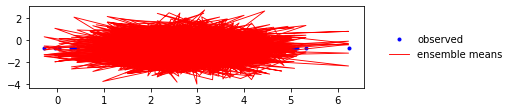

In [619]:
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x_tau0, diff1, 'b.', label='observed');

num_samples = 7
for i in range(num_samples):
    sample_ = yhat.sample().numpy()
    plt.plot(x_tau0,
           sample_[..., 0].T,
           'r',
           linewidth=0.9,
           label='ensemble means' if i == 0 else None);

# plt.ylim(-0.,17);
# plt.yticks(np.linspace(0, 15, 4)[1:]);
# plt.xticks(np.linspace(-10., 10., num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# ax.spines['left'].set_position(('data', 0))
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

In [603]:
vgp = fit(x_tau0, diff1)

In [605]:
vgp.stddev().numpy()

array([1.45091277, 1.44201542, 1.43680471, 1.43439132, 1.43387474,
       1.43455719, 1.43589997, 1.43737175, 1.43835255, 1.43820352,
       1.43654188, 1.4337085 , 1.43138079, 1.4332289 , 1.44539117,
       1.47635679, 1.5357662 , 1.63203286, 1.76962369, 1.94742923,
       2.15895855, 2.39381514, 2.63945956, 2.88268409, 3.11070604,
       3.31197241, 3.4767621 , 3.59762361, 3.6696544 , 3.69061944,
       3.6609122 , 3.58337127, 3.4629773 , 3.30646146, 3.12186055,
       2.91805078, 2.70428504, 2.4897456 , 2.28310771, 2.09209508,
       1.92300724, 1.78023025, 1.66581763, 1.57931333, 1.51799191,
       1.47754087, 1.45298577, 1.43954794, 1.43321139, 1.43095271,
       1.43071496, 1.43124151, 1.43186409, 1.43230193, 1.43249927,
       1.432509  , 1.43241954, 1.43231638, 1.43226792, 1.43232477,
       1.43252366, 1.43288978, 1.43343457, 1.4341497 , 1.43500007,
       1.43592017, 1.43681736, 1.43758355, 1.43811393, 1.43832853,
       1.43819077, 1.43771775, 1.4369786 , 1.43608108, 1.43514

0 171045.55739828516
50 26505.091015717448
100 22352.106683679398
150 19721.18216155629
200 18327.04971062453
250 3017.0474858737703
300 770.8277741669896
350 433.43137553753843
400 465.186293287114
450 215.840339148599
499 196.96415385686964


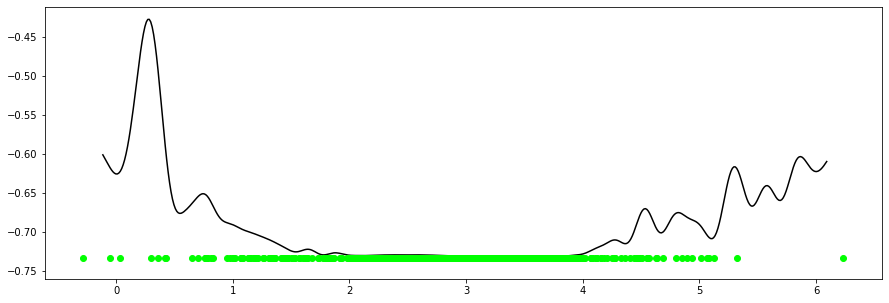

In [604]:
x_train, y_train = x_tau0, diff1

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize(x_train_batch, y_train_batch):
    with tf.GradientTape() as tape:
        # Create the loss function we want to optimize.
        loss = vgp.variational_loss(
            observations=y_train_batch,
            observation_index_points=x_train_batch,
            kl_weight=float(batch_size) / float(N)
        )
    grads = tape.gradient(loss, vgp.trainable_variables)
    optimizer.apply_gradients(zip(grads, vgp.trainable_variables))
    return loss

num_iters = 500
num_logs = 10
for i in range(num_iters):
    batch_idxs = tf.constant(np.random.randint(N, size=[batch_size, 1]))
    x_train_batch_ = tf.gather_nd(x_train, indices=batch_idxs)
    y_train_batch_ = tf.gather_nd(y_train, indices=batch_idxs)

    loss = optimize(x_train_batch, y_train_batch)
    if i % (num_iters / num_logs) == 0 or i + 1 == num_iters:
        print(i, loss.numpy())

samples = tf.reshape(tfd.TransformedDistribution(
    distribution=vgp,
    bijector=tfb.Softplus()
).sample(1), (-1, 1))

#     samples = tf.reshape(vgp.sample(1), (-1, 1))
mean = vgp.mean().numpy()
std = vgp.stddev().numpy()
inducing_index_points_ = inducing_index_points.numpy()
variational_loc_ = variational_loc.numpy()

plt.figure(figsize=(15, 5))
# plt.scatter(inducing_index_points_[..., 0], variational_loc_,
#             marker='x', s=50, color='k', zorder=10)
plt.scatter(x_train[..., 0], y_train, color='#00ff00', zorder=9)
# plt.plot(np.tile(index_points_, (num_samples)),
#           samples.T, color='r', alpha=.1)
plt.plot(index_points_, mean, color='k')

In [598]:
x_tau0.shape[0]

500

0 74324.30034001195
50 13269.421693756705
100 12962.695576602582
150 2752.4830780966986
200 1330.887289717322
250 1316.7823227096635
300 1216.5839626211368
350 470.4149585894985
400 1607.459897183248
450 275.96387955596236
499 215.05463034835964


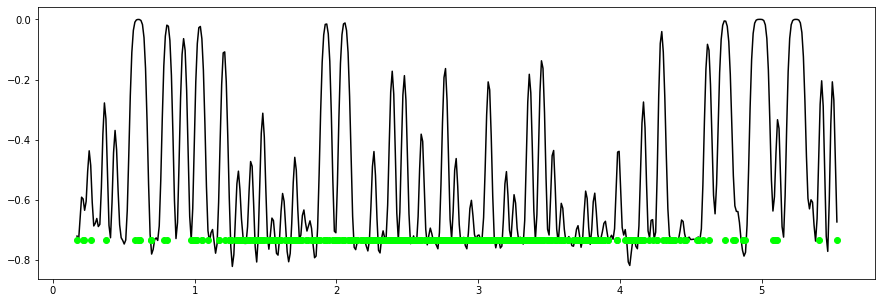

In [590]:
samples1, mean1, std1 = fit(x_tau0, diff1)

In [591]:
diff2 = obs[2] - tf.reshape(samples1, -1)

0 12574.442437521324
50 1473.6665669052857
100 1687.835981085403
150 570.5450093343928
200 5903.227720939073
250 265.76732952533513
300 265.18566523000845
350 263.1248878816659
400 262.5196520062386
450 260.345168494801
499 263.23546087508595


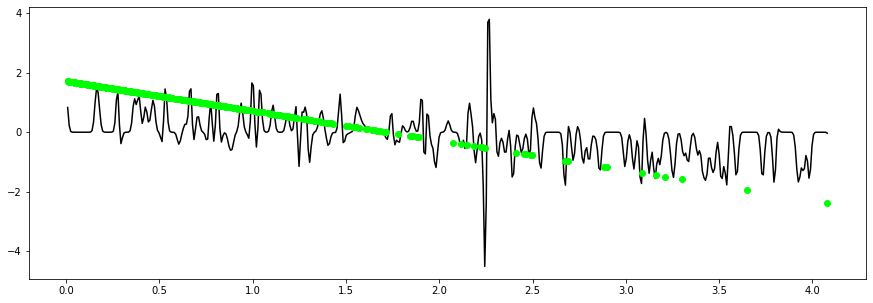

In [593]:
samples2, mean2, std2 = fit(samples1, diff2)

In [454]:
# For training, we use some simplistic numpy-based minibatching.
batch_size = 64

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize(x_train_batch, y_train_batch):
    with tf.GradientTape() as tape:
        # Create the loss function we want to optimize.
        loss = vgp.variational_loss(
            observations=y_train_batch,
            observation_index_points=x_train_batch,
            kl_weight=float(batch_size) / float(N)
        )
    grads = tape.gradient(loss, vgp.trainable_variables)
    optimizer.apply_gradients(zip(grads, vgp.trainable_variables))
    return loss

num_iters = 500
num_logs = 10
for i in range(num_iters):
    batch_idxs = np.random.randint(N, size=[batch_size])
    x_train_batch_ = x_train_[batch_idxs, ...]
    y_train_batch_ = diff[batch_idxs]

    loss = optimize(x_train_batch, y_train_batch)
    if i % (num_iters / num_logs) == 0 or i + 1 == num_iters:
        print(i, loss.numpy())

0 167073.05512465673
50 9606.13373628065
100 8692.15066140085
150 7312.784543554372
200 3263.8581895670254
250 1222.938084184069
300 1009.9121664422073
350 373.9215279054977
400 3218.602102577648
450 174.42122695854772
499 170.9949245413389


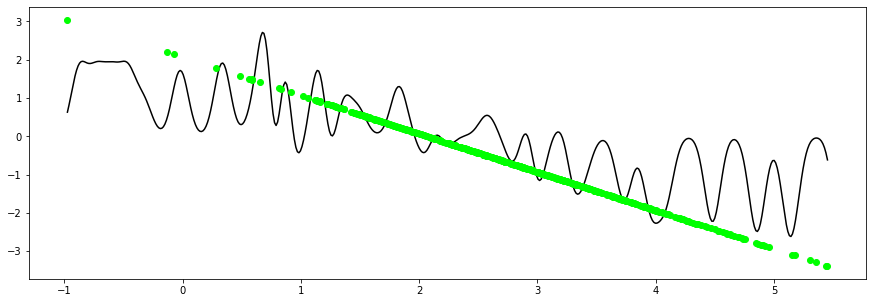

In [456]:
samples = vgp.sample(1).numpy()
mean = vgp.mean().numpy()
inducing_index_points_ = inducing_index_points.numpy()
variational_loc_ = variational_loc.numpy()

plt.figure(figsize=(15, 5))
# plt.scatter(inducing_index_points_[..., 0], variational_loc_,
#             marker='x', s=50, color='k', zorder=10)
plt.scatter(x_tau0[..., 0], diff1, color='#00ff00', zorder=9)
# plt.plot(np.tile(index_points_, (num_samples)),
#           samples.T, color='r', alpha=.1)
plt.plot(index_points_, mean, color='k')

In [467]:
diff2 = obs[2] - tf.reshape(samples, -1)
x1_min, x1_max = samples.min(), samples.max()

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [204]:
obs

array([2.80104117, 2.06760356, 1.71678728, 1.519752  , 1.41148181,
       1.29857278, 1.27016041, 1.22695974, 1.17189095, 1.16614779,
       1.12695298, 1.1012704 , 1.05749356, 1.03615041, 1.00607013,
       0.99874352, 0.98238381, 1.00281176, 0.96565932, 0.99254011,
       0.96176698, 0.95434694, 0.97069245, 0.94877561, 0.95226573,
       0.95195953, 0.94064689, 0.95527826, 0.93799316, 0.94497026,
       0.98362845, 0.91061173, 0.94652162, 0.95570852, 0.9348896 ,
       0.92749876, 0.90598237, 0.9178948 , 0.93248146, 0.93212938,
       0.89558187, 0.95192011, 0.91844298, 0.97379033, 0.93604319,
       0.95376289, 0.91205494, 0.93994464, 0.93984213, 0.90327863,
       0.94603579, 0.91564944, 0.9364877 , 0.91708708, 0.9367608 ,
       0.93480819, 0.92543156, 0.91513496, 0.92454856, 0.9107423 ,
       0.92889546, 0.93827121, 0.94129805, 0.93547443, 0.91507036,
       0.93925102, 0.92939488, 0.93963748, 0.94736802, 0.89803601,
       0.91210008, 0.94996609, 0.91881743, 0.93845888, 0.95542

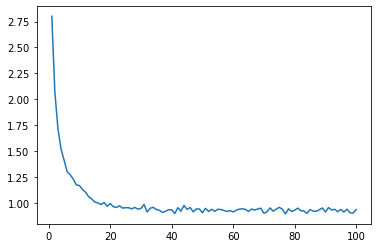

In [190]:
t = np.linspace(0, 100, 101)
plt.plot(t[1:], data)

In [256]:
y_train_.shape

(1000,)

0 214783.56490137984
1000 143.30109703750875
2000 108.3948397217366
3000 20.651431449761848
4000 19.659717132906923
5000 19.466304032941245
6000 13.543920037399097
7000 8.233720430152497
8000 13.970502298378607
9000 10.111857337174559
9999 11.128335719044973


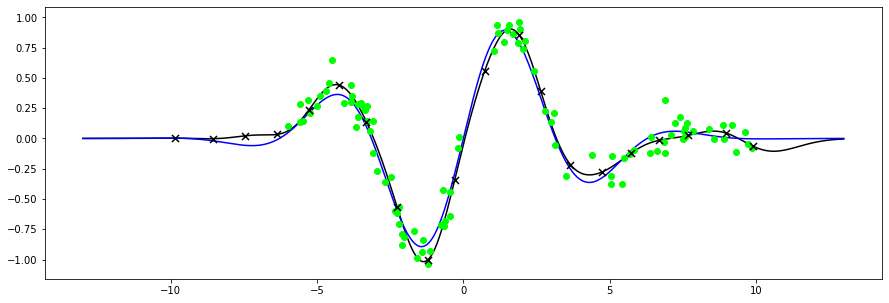

In [294]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

# We'll use double precision throughout for better numerics.
dtype = np.float64

# Generate noisy data from a known function.
f = lambda x: np.exp(-x[..., 0]**2 / 20.) * np.sin(1. * x[..., 0])
true_observation_noise_variance_ = dtype(1e-1) ** 2

num_training_points_ = 100
x_train_ = np.concatenate(
    [np.random.uniform(-6., 0., [num_training_points_ // 2 , 1]),
    np.random.uniform(1., 10., [num_training_points_ // 2 , 1])],
    axis=0).astype(dtype)
y_train_ = (f(x_train_) +
            np.random.normal(
                0., np.sqrt(true_observation_noise_variance_),
                [num_training_points_]).astype(dtype))

# Create kernel with trainable parameters, and trainable observation noise
# variance variable. Each of these is constrained to be positive.
amplitude = tfp.util.TransformedVariable(
    1., tfb.Softplus(), dtype=dtype, name='amplitude')
length_scale = tfp.util.TransformedVariable(
    1., tfb.Softplus(), dtype=dtype, name='length_scale')
kernel = tfk.ExponentiatedQuadratic(
    amplitude=amplitude,
    length_scale=length_scale)

observation_noise_variance = tfp.util.TransformedVariable(
    1., tfb.Softplus(), dtype=dtype, name='observation_noise_variance')

# Create trainable inducing point locations and variational parameters.
num_inducing_points_ = 20
inducing_index_points = tf.Variable(
    np.linspace(-5., 5., num_inducing_points_)[..., np.newaxis],
    dtype=dtype, name='inducing_index_points')
b = tf.Variable(
    np.zeros([num_inducing_points_], dtype=dtype),
    name='variational_inducing_observations_loc')
variational_inducing_observations_scale = tf.Variable(
    np.eye(num_inducing_points_, dtype=dtype),
    name='variational_inducing_observations_scale')

# These are the index point locations over which we'll construct the
# (approximate) posterior predictive distribution.
num_predictive_index_points_ = 500
index_points_ = np.linspace(-13, 13,
                            num_predictive_index_points_,
                            dtype=dtype)[..., np.newaxis]

# Construct our variational GP Distribution instance.
vgp = tfd.VariationalGaussianProcess(
    kernel,
    index_points=index_points_,
    inducing_index_points=inducing_index_points,
    variational_inducing_observations_loc=
        variational_inducing_observations_loc,
    variational_inducing_observations_scale=
        variational_inducing_observations_scale,
    observation_noise_variance=observation_noise_variance)

# For training, we use some simplistic numpy-based minibatching.
batch_size = 64

optimizer = tf.optimizers.Adam(learning_rate=.1)

@tf.function
def optimize(x_train_batch, y_train_batch):
  with tf.GradientTape() as tape:
    # Create the loss function we want to optimize.
    loss = vgp.variational_loss(
        observations=y_train_batch,
        observation_index_points=x_train_batch,
        kl_weight=float(batch_size) / float(num_training_points_))
  grads = tape.gradient(loss, vgp.trainable_variables)
  optimizer.apply_gradients(zip(grads, vgp.trainable_variables))
  return loss

num_iters = 10000
num_logs = 10
for i in range(num_iters):
  batch_idxs = np.random.randint(num_training_points_, size=[batch_size])
  x_train_batch = x_train_[batch_idxs, ...]
  y_train_batch = y_train_[batch_idxs]
  loss = optimize(x_train_batch, y_train_batch)

  if i % (num_iters / num_logs) == 0 or i + 1 == num_iters:
    print(i, loss.numpy())

# Generate a plot with
#   - the posterior predictive mean
#   - training data
#   - inducing index points (plotted vertically at the mean of the variational
#     posterior over inducing point function values)
#   - 50 posterior predictive samples

num_samples = 50
samples = vgp.sample(num_samples).numpy()
mean = vgp.mean().numpy()
inducing_index_points_ = inducing_index_points.numpy()
variational_loc = variational_inducing_observations_loc.numpy()

plt.figure(figsize=(15, 5))
plt.scatter(inducing_index_points_[..., 0], variational_loc,
            marker='x', s=50, color='k', zorder=10)
plt.scatter(x_train_[..., 0], y_train_, color='#00ff00', zorder=9)
# plt.plot(np.tile(index_points_, (num_samples)),
#           samples.T, color='r', alpha=.1)
plt.plot(index_points_, mean, color='k')
plt.plot(index_points_, f(index_points_), color='b')

0 99.53983067694796
30 54.877552153118934
60 16.804002067657567
90 3.807501054722535
120 3.280462954540015
150 3.2761990111228334
180 3.2747998201612534
210 3.273927410463868
240 3.273493796353726
270 3.276933593665019
299 3.2730745730864284


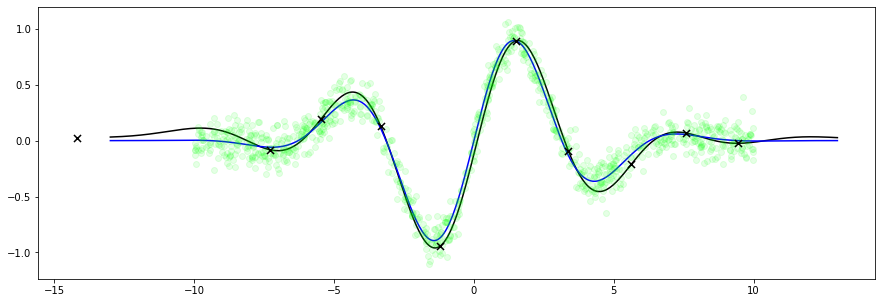

In [302]:
# We'll use double precision throughout for better numerics.
dtype = np.float64

# Generate noisy data from a known function.
f = lambda x: np.exp(-x[..., 0]**2 / 20.) * np.sin(1. * x[..., 0])
true_observation_noise_variance_ = dtype(1e-1) ** 2

num_training_points_ = 1000
x_train_ = np.random.uniform(-10., 10., [num_training_points_, 1])
y_train_ = (f(x_train_) +
            np.random.normal(
                0., np.sqrt(true_observation_noise_variance_),
                [num_training_points_]))

# Create kernel with trainable parameters, and trainable observation noise
# variance variable. Each of these is constrained to be positive.
amplitude = tfp.util.TransformedVariable(
    1., tfb.Softplus(), dtype=dtype, name='amplitude')
length_scale = tfp.util.TransformedVariable(
    1., tfb.Softplus(), dtype=dtype, name='length_scale')
kernel = tfk.ExponentiatedQuadratic(
    amplitude=amplitude,
    length_scale=length_scale)

observation_noise_variance = tfp.util.TransformedVariable(
    1., tfb.Softplus(), dtype=dtype, name='observation_noise_variance')

# Create trainable inducing point locations and variational parameters.
num_inducing_points_ = 10

inducing_index_points = tf.Variable(
    np.linspace(-10., 10., num_inducing_points_)[..., np.newaxis],
    dtype=dtype, name='inducing_index_points')

variational_loc, variational_scale = (
    tfd.VariationalGaussianProcess.optimal_variational_posterior(
        kernel=kernel,
        inducing_index_points=inducing_index_points,
        observation_index_points=x_train_,
        observations=y_train_,
        observation_noise_variance=observation_noise_variance))

# These are the index point locations over which we'll construct the
# (approximate) posterior predictive distribution.
num_predictive_index_points_ = 500
index_points_ = np.linspace(-13, 13,
                            num_predictive_index_points_,
                            dtype=dtype)[..., np.newaxis]

# Construct our variational GP Distribution instance.
vgp = tfd.VariationalGaussianProcess(
    kernel,
    index_points=index_points_,
    inducing_index_points=inducing_index_points,
    variational_inducing_observations_loc=variational_loc,
    variational_inducing_observations_scale=variational_scale,
    observation_noise_variance=observation_noise_variance)

# For training, we use some simplistic numpy-based minibatching.
batch_size = 64

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize(x_train_batch, y_train_batch):
  with tf.GradientTape() as tape:
    # Create the loss function we want to optimize.
    loss = vgp.variational_loss(
        observations=y_train_batch,
        observation_index_points=x_train_batch,
        kl_weight=float(batch_size) / float(num_training_points_))
  grads = tape.gradient(loss, vgp.trainable_variables)
  optimizer.apply_gradients(zip(grads, vgp.trainable_variables))
  return loss

num_iters = 300
num_logs = 10
for i in range(num_iters):
  batch_idxs = np.random.randint(num_training_points_, size=[batch_size])
  x_train_batch_ = x_train_[batch_idxs, ...]
  y_train_batch_ = y_train_[batch_idxs]

  loss = optimize(x_train_batch, y_train_batch)
  if i % (num_iters / num_logs) == 0 or i + 1 == num_iters:
    print(i, loss.numpy())

# Generate a plot with
#   - the posterior predictive mean
#   - training data
#   - inducing index points (plotted vertically at the mean of the
#     variational posterior over inducing point function values)
#   - 50 posterior predictive samples

num_samples = 50

samples_ = vgp.sample(num_samples).numpy()
mean_ = vgp.mean().numpy()
inducing_index_points_ = inducing_index_points.numpy()
variational_loc_ = variational_loc.numpy()

plt.figure(figsize=(15, 5))
plt.scatter(inducing_index_points_[..., 0], variational_loc_,
            marker='x', s=50, color='k', zorder=10)
plt.scatter(x_train_[..., 0], y_train_, color='#00ff00', alpha=.1, zorder=9)
# plt.plot(np.tile(index_points_, num_samples),
#           samples_.T, color='r', alpha=.1)
plt.plot(index_points_, mean_, color='k')
plt.plot(index_points_, f(index_points_), color='b')